# Check out Pb fields from test runs

In [94]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
import xarray as xr

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

# Resolution of grid cells to show in figure:
grid_reso  = 10

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,777,797) # Northern Canada Basin
bdy_WCB = (2167,2177,390,797) # Western Canada Basin
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,291,301) # Hudson Bay
land_color  = '#a9a7a2'

#### Load files:

In [3]:
mfile    = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = np.array(mfile.variables['nav_lon'])
mesh_lat = np.array(mfile.variables['nav_lat'])
mask     = np.array(mfile.variables['tmask'][0])
mesh_bathy   = np.array(mfile.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = np.array(mfile.variables['nav_lev'])

In [48]:
def load_comps(folder, month=1):
    
    comp = nc.Dataset(f'{folder}ANHA12_EXH006_1m_20150101_20151231_comp_2015{month:02}-2015{month:02}.nc')

    dpb         = np.array(comp.variables['dissolpb'])[:,:,:]
    dpb_sed     = np.array(comp.variables['dpbsed'])[:,:,:]
    dpb_sedice  = np.array(comp.variables['dpbsedice'])[:,:,:]
    dpb_ads     = np.array(comp.variables['dpbads'])[:,:,:]
    dpb_icedust = np.array(comp.variables['dpbicedust'])[:,:,:]
    dpb_icebc   = np.array(comp.variables['dpbicebc'])[:,:,:]
    dpb_atmdust = np.array(comp.variables['dpbatmdust'])[:,:,:]
    dpb_atmbc   = np.array(comp.variables['dpbatmbc'])[:,:,:]
    dpb_riv     = np.array(comp.variables['dpbriv'])[:,:,:]

    print(f'----------------- Month: {month:02} ----------------------------')
    print(f'Resuspension:    {np.mean(dpb_sed):.2e} ({np.amin(dpb_sed):.2e}  - {np.amax(dpb_sed):.2e})')
    print(f'Sediment ice:    {np.mean(dpb_sedice):.2e} ({np.amin(dpb_sedice):.2e}  - {np.amax(dpb_sedice):.2e})')
    print(f'Adsorption:      {np.mean(dpb_ads):.2e} ({np.amin(dpb_ads):.2e}  - {np.amax(dpb_ads):.2e})')
    print(f'Ice flux dust:   {np.mean(dpb_icedust):.2e} ({np.amin(dpb_icedust):.2e}  - {np.amax(dpb_icedust):.2e})')
    print(f'Ice flux bc:     {np.mean(dpb_icebc):.2e} ({np.amin(dpb_icebc):.2e}  - {np.amax(dpb_icebc):.2e})')
    print(f'Atmosphere dust: {np.mean(dpb_atmdust):.2e} ({np.amin(dpb_atmdust):.2e}  - {np.amax(dpb_atmdust):.2e})')
    print(f'Atmosphere bc:   {np.mean(dpb_atmbc):.2e} ({np.amin(dpb_atmbc):.2e}  - {np.amax(dpb_atmbc):.2e})')
    print(f'River runoff:    {np.mean(dpb_riv):.2e} ({np.amin(dpb_riv):.2e}  - {np.amax(dpb_riv):.2e})')
    
    return dpb, dpb_sed, dpb_sedice, dpb_ads, \
            dpb_icedust, dpb_icebc, dpb_atmdust, dpb_atmbc, \
            dpb_riv

In [50]:
folder = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-new-ini-particle0005-kscav05/'
dpb01, dpb_sed01, dpb_sedice01, dpb_ads01, dpb_icedust01, dpb_icebc01, dpb_atmdust01, dpb_atmbc01, \
            dpb_riv01 = load_comps(folder, month=1)
dpb02, dpb_sed02, dpb_sedice02, dpb_ads02, dpb_icedust02, dpb_icebc02, dpb_atmdust02, dpb_atmbc02, \
            dpb_riv02 = load_comps(folder, month=2)
dpb03, dpb_sed03, dpb_sedice03, dpb_ads03, dpb_icedust03, dpb_icebc03, dpb_atmdust03, dpb_atmbc03, \
            dpb_riv03 = load_comps(folder, month=3)

----------------- Month: 01 ----------------------------
Resuspension:    8.06e-19 (0.00e+00  - 1.05e-16)
Sediment ice:    2.11e-20 (0.00e+00  - 2.91e-17)
Adsorption:      4.39e-20 (0.00e+00  - 1.48e-17)
Ice flux dust:   1.19e-21 (0.00e+00  - 2.21e-19)
Ice flux bc:     7.42e-20 (0.00e+00  - 2.36e-18)
Atmosphere dust: 1.33e-20 (1.53e-26  - 2.13e-18)
Atmosphere bc:   1.16e-18 (6.41e-24  - 1.34e-17)
River runoff:    7.87e-20 (0.00e+00  - 9.45e-16)
----------------- Month: 02 ----------------------------
Resuspension:    8.06e-19 (0.00e+00  - 1.05e-16)
Sediment ice:    5.62e-21 (0.00e+00  - 2.89e-17)
Adsorption:      1.35e-20 (0.00e+00  - 1.47e-17)
Ice flux dust:   2.46e-22 (0.00e+00  - 9.34e-21)
Ice flux bc:     9.68e-20 (0.00e+00  - 6.55e-18)
Atmosphere dust: 1.91e-21 (8.33e-27  - 4.74e-20)
Atmosphere bc:   7.35e-19 (5.76e-24  - 1.25e-17)
River runoff:    7.66e-20 (0.00e+00  - 8.51e-16)
----------------- Month: 03 ----------------------------
Resuspension:    8.06e-19 (0.00e+00  - 1.05e-

In [84]:
dpb_neg = np.copy(dpb03[0,:,:,:])
dpb_neg[dpb[0,:,:,:] >= 0] = np.nan
dpb_neg_loc = np.nansum(dpb_neg, axis=0)

# create mask based on where the negative values are:
dpb_neg_values = np.ma.masked_where(dpb03[0,:,:,:] < 0, dpb03[0,:,:,:])
dpb_neg_3D_mask = dpb_neg_values.mask
dpb_neg_2D_mask = np.ma.masked_where(dpb_neg_loc!=0, dpb_neg_loc).mask

In [52]:
np.ma.count_masked(dpb_neg_values)

73

In [99]:
def load_forcing(folder, month):
    # scavenging:
    scav = xr.open_dataset(f'{folder}Pb_scavenging_y2015m{month:02}.nc')
    scav_litho = scav['lithogenic'].values[:,imin:imax,jmin:jmax]
    scav_bio   = scav['biogenic'].values[:,imin:imax,jmin:jmax]
    
    return scav_litho, scav_bio

In [100]:
print('Where concentrations become negative: model output')

print('Mean dpb in month 01:     ', np.mean(dpb01[0,dpb_neg_3D_mask]))
print('Mean dpb in month 02:     ', np.mean(dpb02[0,dpb_neg_3D_mask]))

print('Mean dpb_ads in month 01: ', np.mean(dpb_ads01[0,dpb_neg_3D_mask]))
print('Mean dpb_ads in month 02: ', np.mean(dpb_ads02[0,dpb_neg_3D_mask]))

print('Mean dpb_sed in month 01: ', np.mean(dpb_sed01[0,dpb_neg_2D_mask]))
print('Mean dpb_sed in month 02: ', np.mean(dpb_sed02[0,dpb_neg_2D_mask]))

Where concentrations become negative: model output
Mean dpb in month 01:      2.8063097e-12
Mean dpb in month 02:      5.6871863e-13
Mean dpb_ads in month 01:  1.3970878e-18
Mean dpb_ads in month 02:  2.8313576e-19
Mean dpb_sed in month 01:  3.595925e-21
Mean dpb_sed in month 02:  3.595925e-21


In [102]:
# Load model forcing and check values for particle abundance etc.
folder='/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/particle0005/'

scav_litho01, scav_bio01 = load_forcing(folder, 1)
scav_litho02, scav_bio02 = load_forcing(folder, 2)
scav_litho03, scav_bio03 = load_forcing(folder, 3)

In [103]:
scav_litho01.shape

(50, 1040, 640)

In [107]:
print('Where concentrations become negative: model forcing')

print('Mean scav_litho in month 01: ', np.mean(scav_litho01[dpb_neg_3D_mask]))
print('Mean scav_litho in month 02: ', np.mean(scav_litho02[dpb_neg_3D_mask]))
print('Mean scav_bio in month 01:   ', np.mean(scav_bio01[dpb_neg_3D_mask]))
print('Mean scav_bio in month 02:   ', np.mean(scav_bio02[dpb_neg_3D_mask]))

Where concentrations become negative: model forcing
Mean scav_litho in month 01:  6.368768985115297e-05
Mean scav_litho in month 02:  6.415194398021862e-05
Mean scav_bio in month 01:    0.09950000000000002
Mean scav_bio in month 02:    0.09950000000000002


In [ ]:
# Check cells nearby that don't become negative and what happens there

In [7]:
for depth in range(0,50):
    print(f'Min: {depth}, {np.ma.min(dpb_m[depth,:,:]):.2e}, max: {np.ma.max(dpb_m[depth,:,:]):.2e}')

Min: 0, 0.00e+00, max: 2.43e-11
Min: 1, 0.00e+00, max: 2.43e-11
Min: 2, 0.00e+00, max: 2.43e-11
Min: 3, 0.00e+00, max: 2.43e-11
Min: 4, 0.00e+00, max: 2.43e-11
Min: 5, 0.00e+00, max: 2.43e-11
Min: 6, 0.00e+00, max: 2.43e-11
Min: 7, 0.00e+00, max: 2.43e-11
Min: 8, 0.00e+00, max: 2.74e-11
Min: 9, 0.00e+00, max: 2.75e-11
Min: 10, 0.00e+00, max: 2.51e-11
Min: 11, 0.00e+00, max: 2.76e-11
Min: 12, 0.00e+00, max: 2.87e-11
Min: 13, 0.00e+00, max: 3.39e-11
Min: 14, 0.00e+00, max: 4.81e-11
Min: 15, 0.00e+00, max: 2.59e-11
Min: 16, 0.00e+00, max: 2.67e-11
Min: 17, 0.00e+00, max: 3.71e-11
Min: 18, 0.00e+00, max: 2.76e-11
Min: 19, 0.00e+00, max: 3.03e-11
Min: 20, 0.00e+00, max: 2.61e-11
Min: 21, 0.00e+00, max: 2.72e-11
Min: 22, 0.00e+00, max: 2.70e-11
Min: 23, -7.83e-15, max: 2.73e-11
Min: 24, 0.00e+00, max: 2.74e-11
Min: 25, -2.24e-15, max: 2.75e-11
Min: 26, -3.55e-13, max: 2.76e-11
Min: 27, -1.84e-13, max: 2.78e-11
Min: 28, 0.00e+00, max: 2.79e-11
Min: 29, 0.00e+00, max: 2.80e-11
Min: 30, 0.00e+0

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  


#### Figure:

In [8]:
def plot_weird(variable, layer):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    variable_plot = np.ma.masked_where(variable[layer,:,:] > 0, variable[layer,:,:])
    x_plot   = x[~variable_plot.mask]
    y_plot   = y[~variable_plot.mask]
    var_plot = variable_plot[~variable_plot.mask] 
    
    CB = proj1.scatter(x_plot, y_plot, c=var_plot*1e12, s=5)

    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
    CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

In [32]:
def plot_layer(variable, vmin=0, vmax=30):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
#     CB = proj1.pcolormesh(x, y, variable, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax) 
    proj1.scatter(x[variable < 0], y[variable < 0], s=10, edgecolor='k', linewidth=0.5, zorder=5)
    
#     ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)
    
    # Color bar: --------------------------------------------------------------------------------
#     cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
#     CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
#     CBar.set_label('Dissolved Pb [pM]', fontsize=7)
#     CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

In [13]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

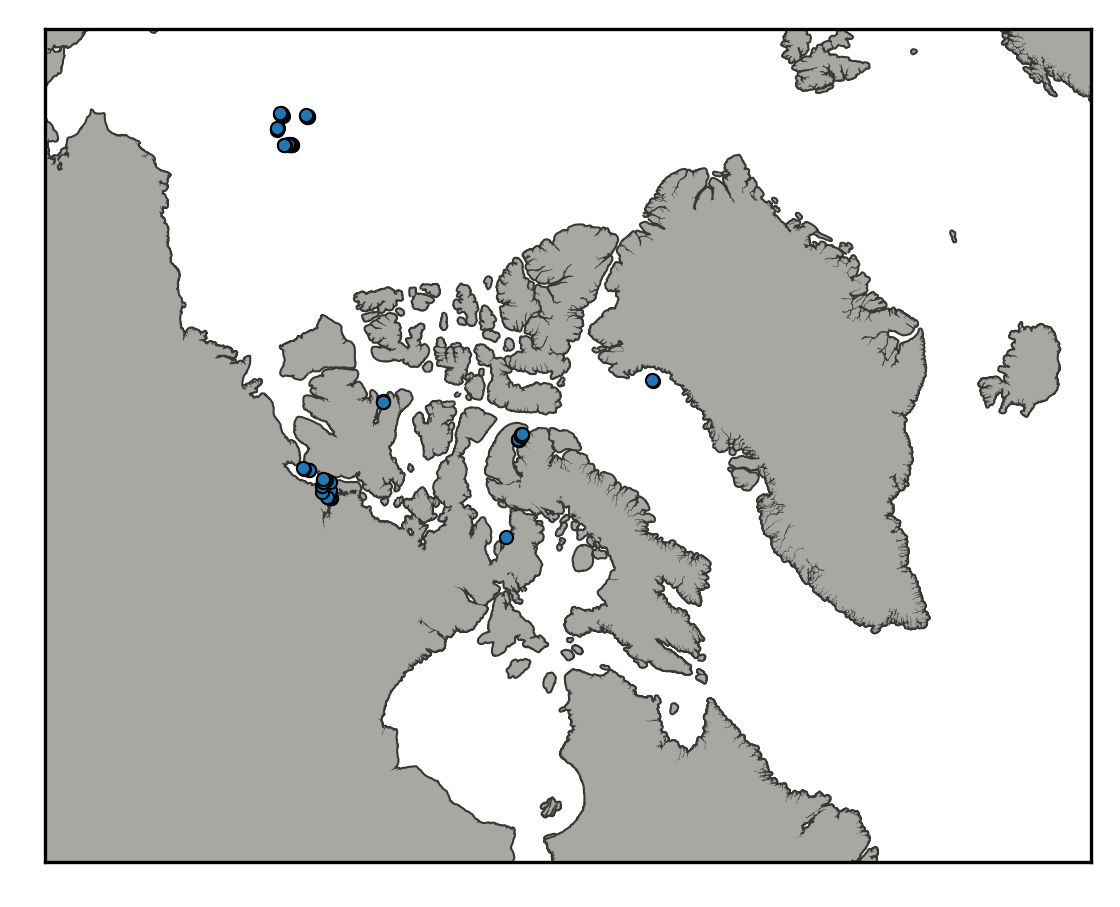

In [33]:
plot_layer(dpb_neg_loc, vmin=-1e-20, vmax=0)

In [ ]:
plot_layer(dpb, 0, vmin=0, vmax=20)

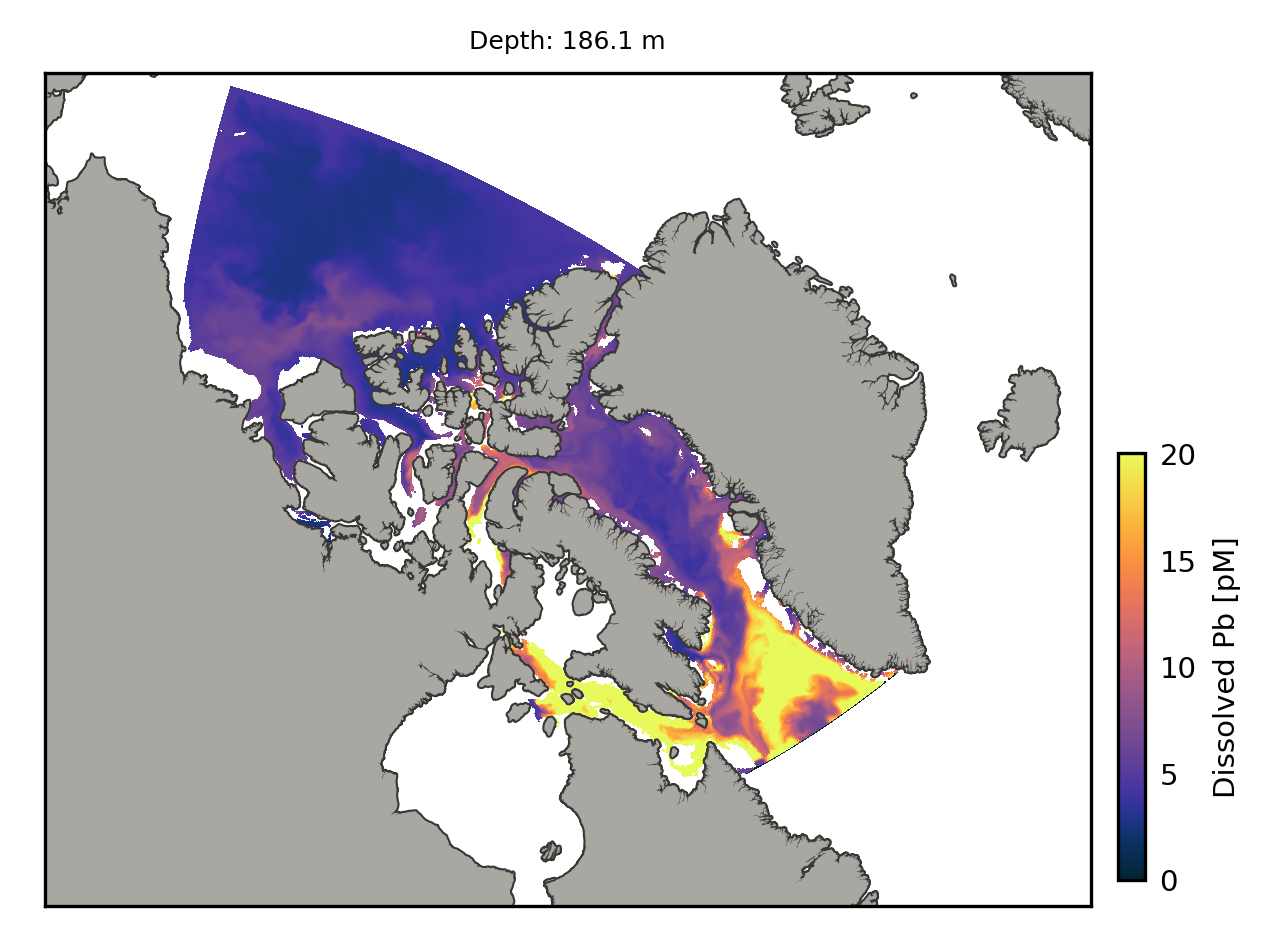

In [41]:
plot_layer(dpb, 25, vmin=0, vmax=20)

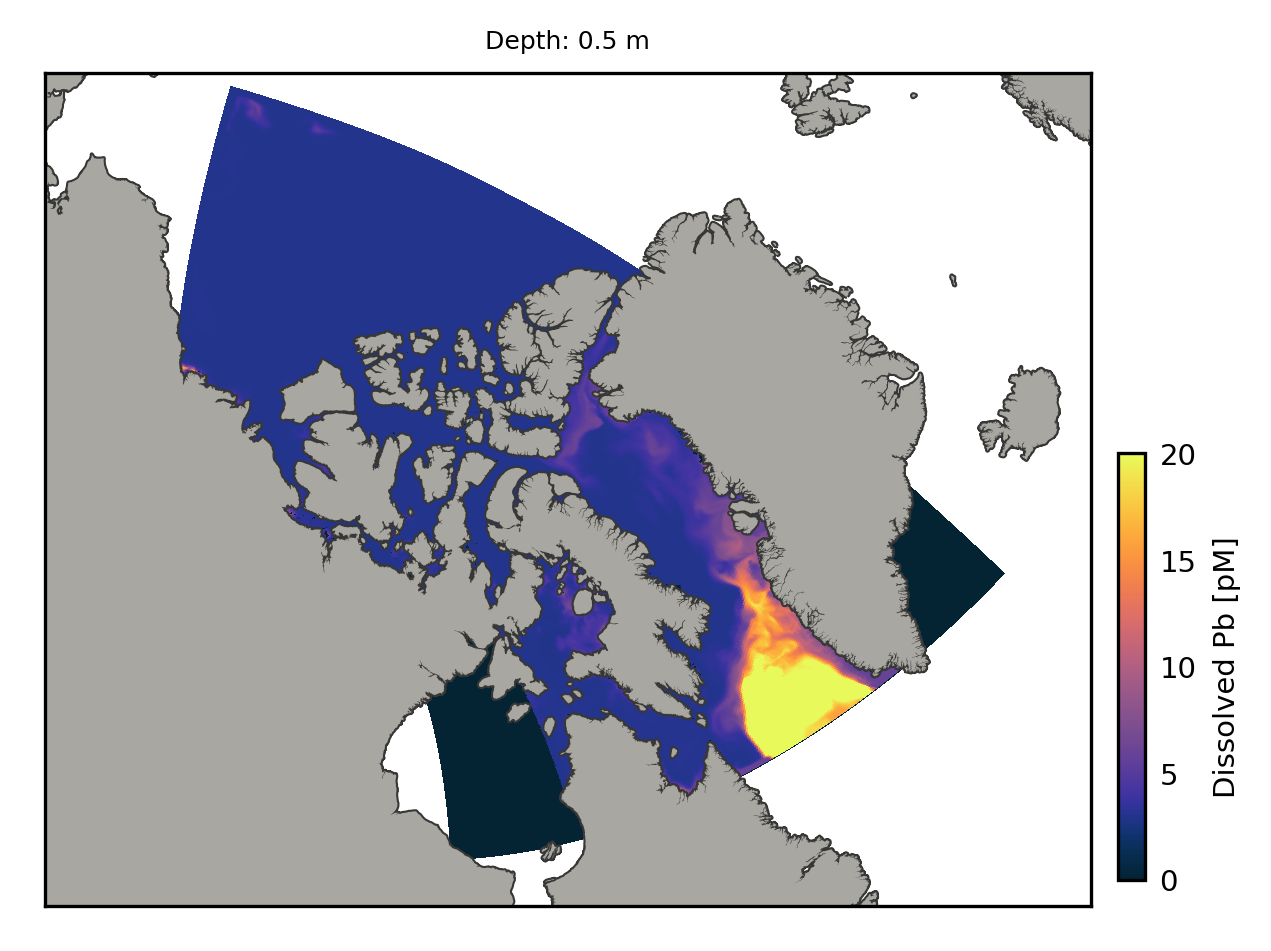

In [41]:
plot_layer(dpb[0,:,:,:], 0, vmin=0, vmax=20)

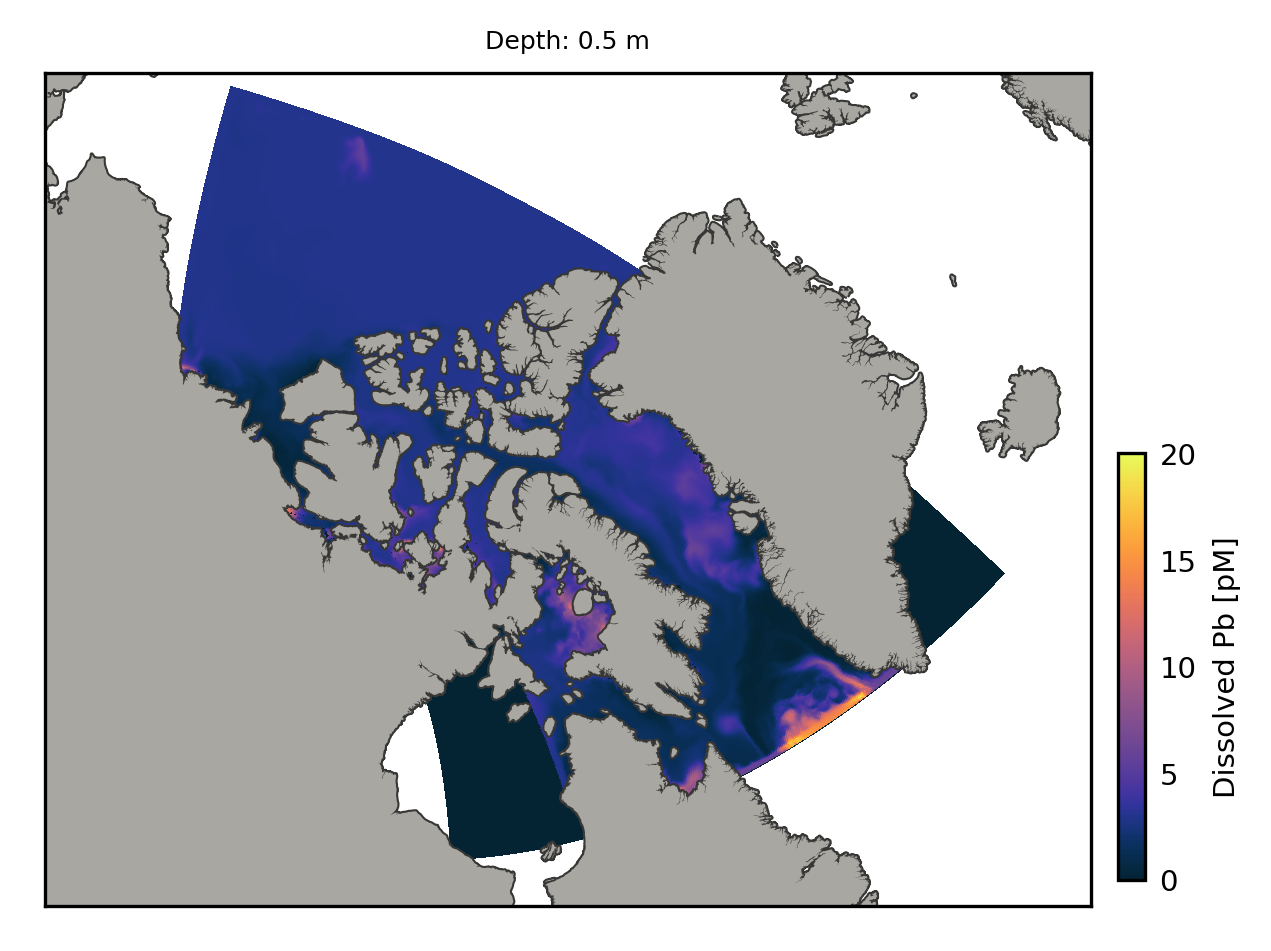

In [50]:
plot_layer(dpb[0,:,:,:], 0, vmin=0, vmax=20)

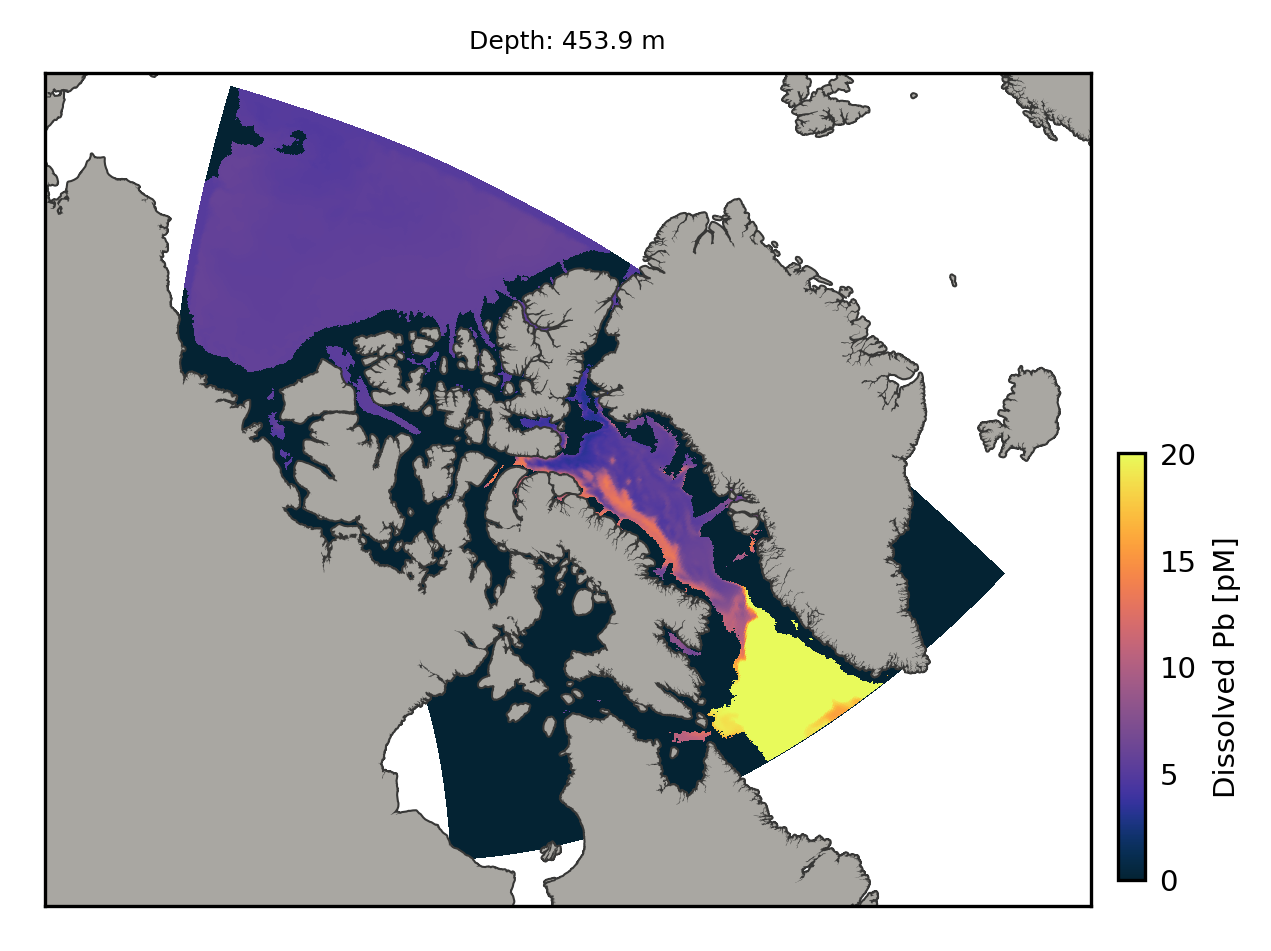

In [57]:
plot_layer(dpb[0,:,:,:], 30, vmin=0, vmax=20)

In [ ]:
plot_layer(dpb[0,:,:,:], 30, vmin=0, vmax=20)

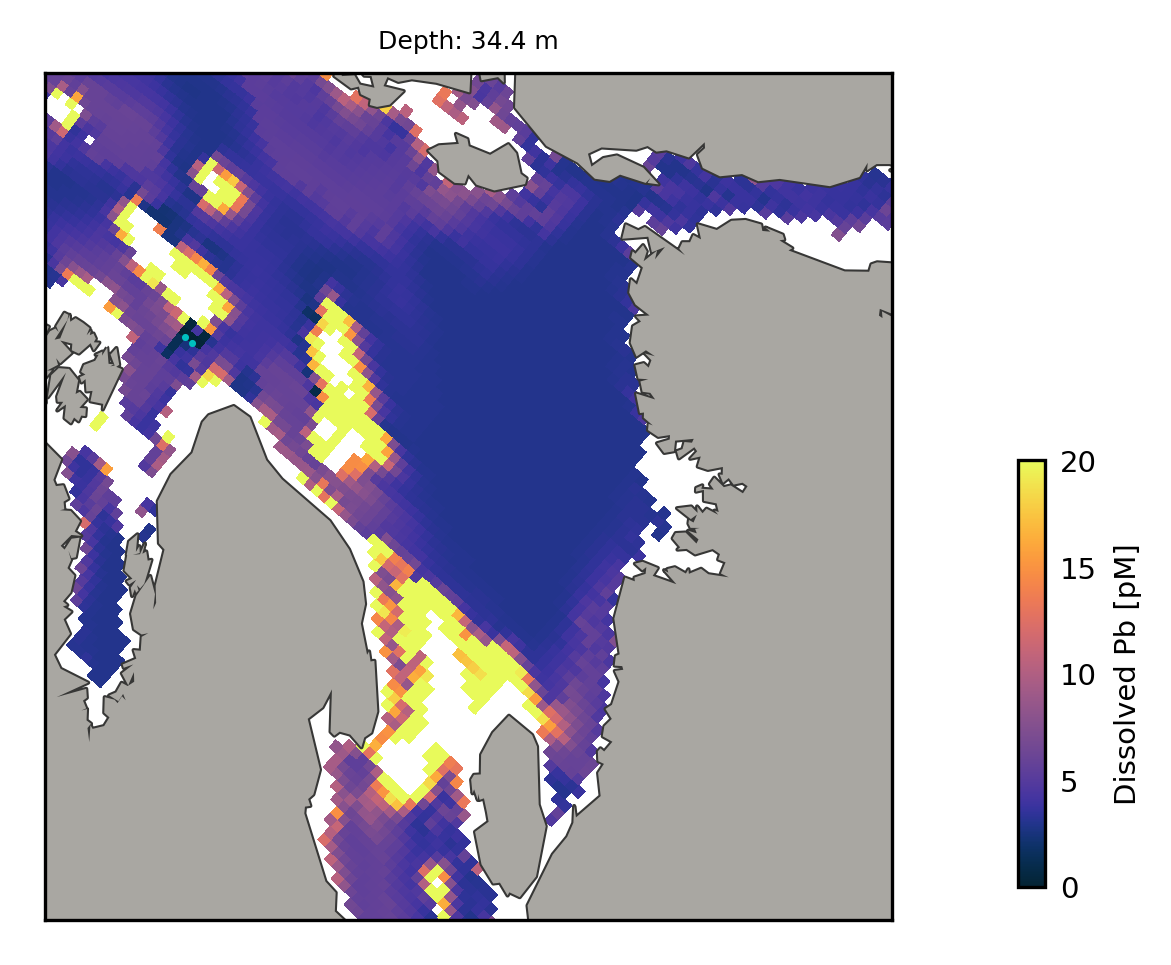

In [36]:
plot_layer_zoom(dpb, 15, vmin=0, vmax=20)

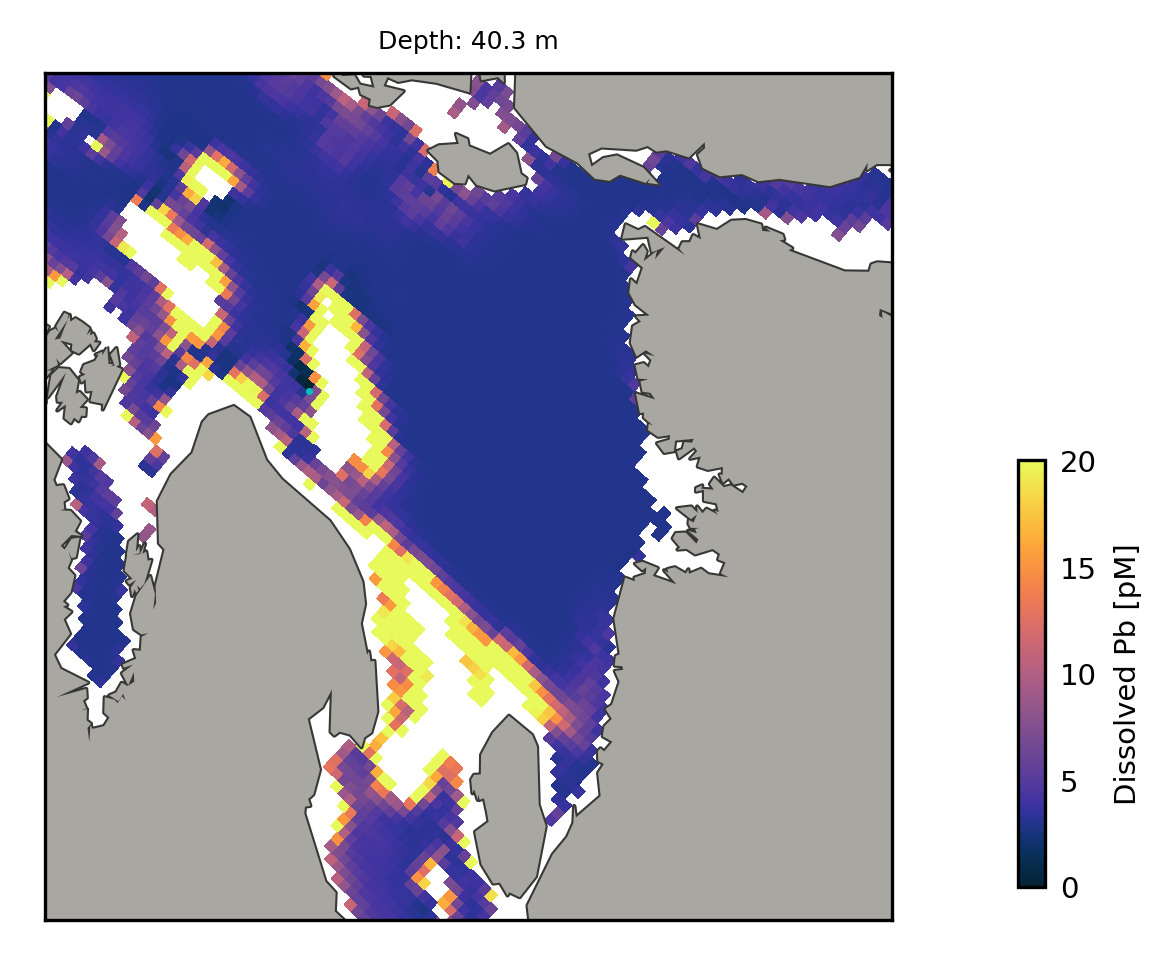

In [37]:
plot_layer_zoom(dpb, 16, vmin=0, vmax=20)

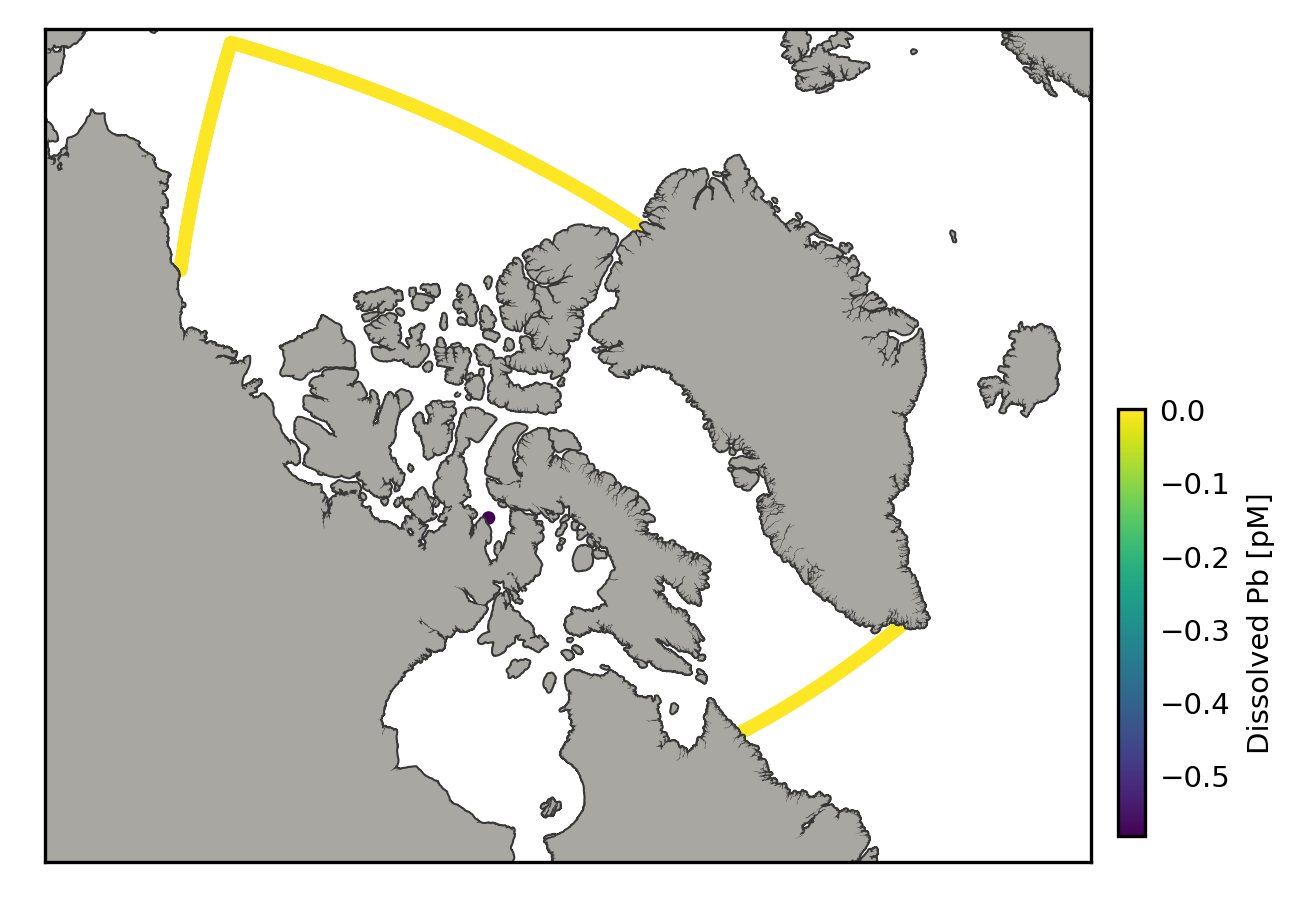

In [12]:
plot_weird(dpb, 16)

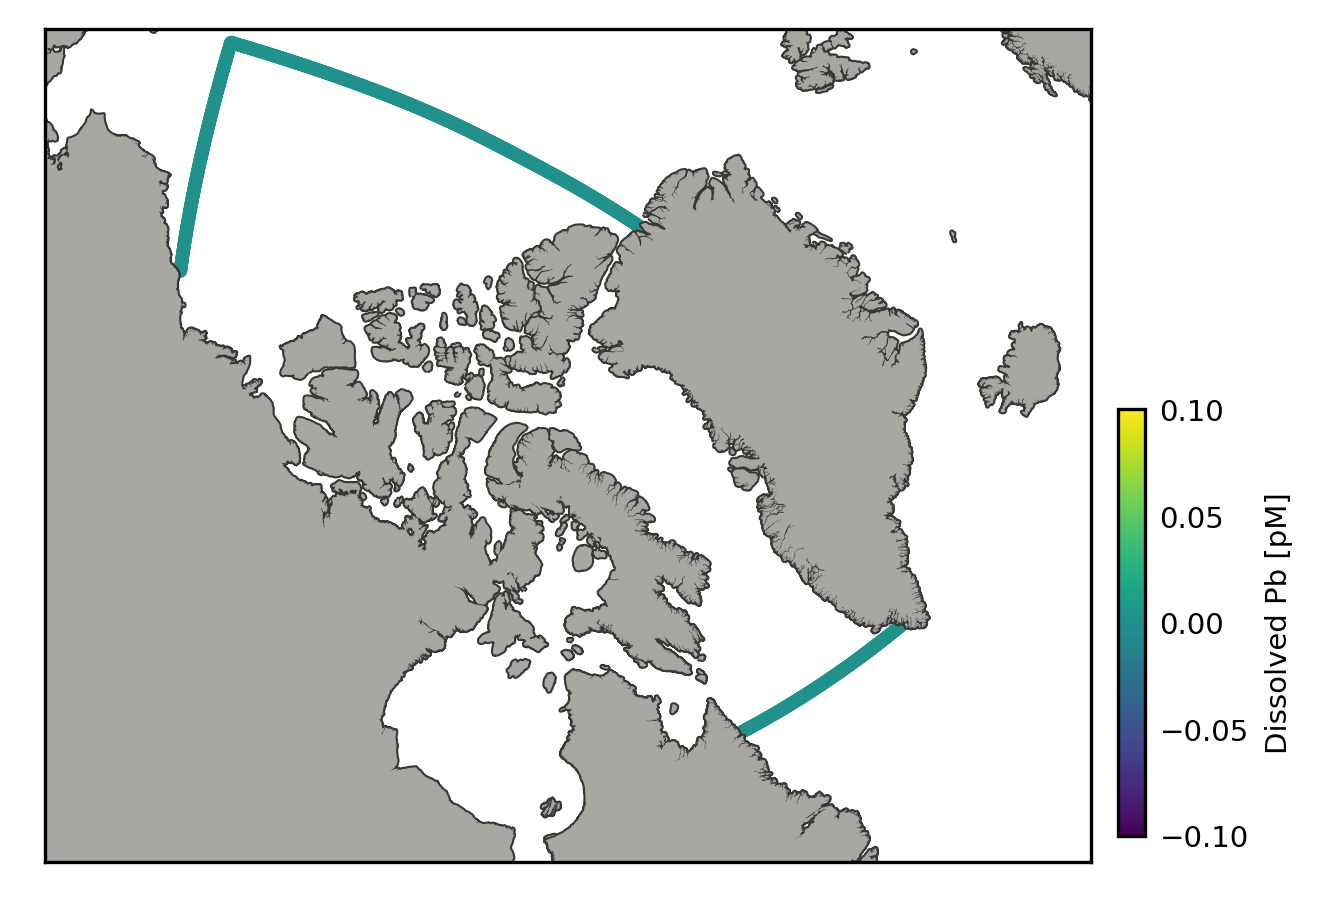

In [18]:
# resus
plot_weird(dpb, 15)

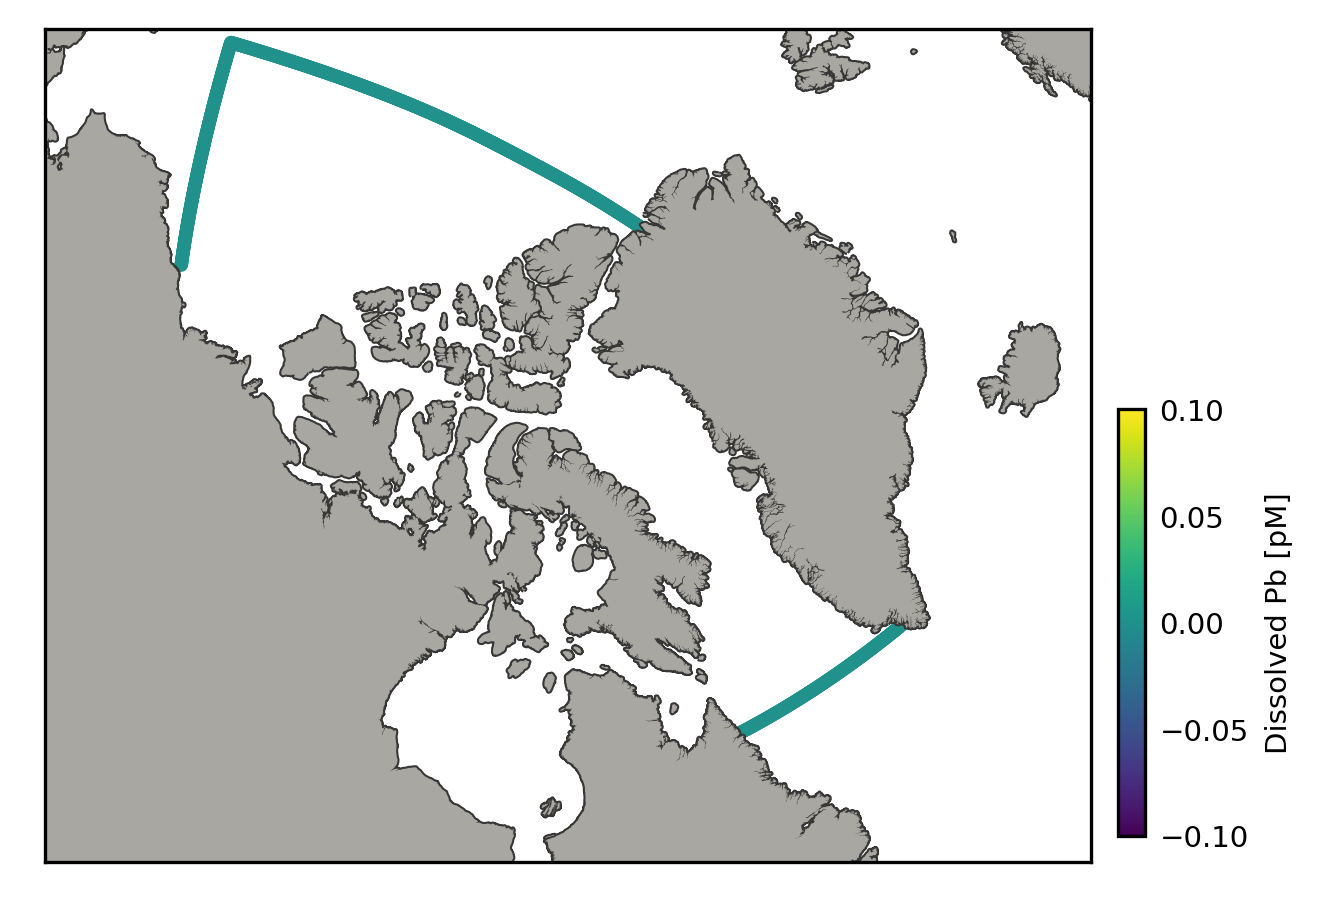

In [66]:
# sedice
plot_weird(dpb, 17)

#### Depth profiles

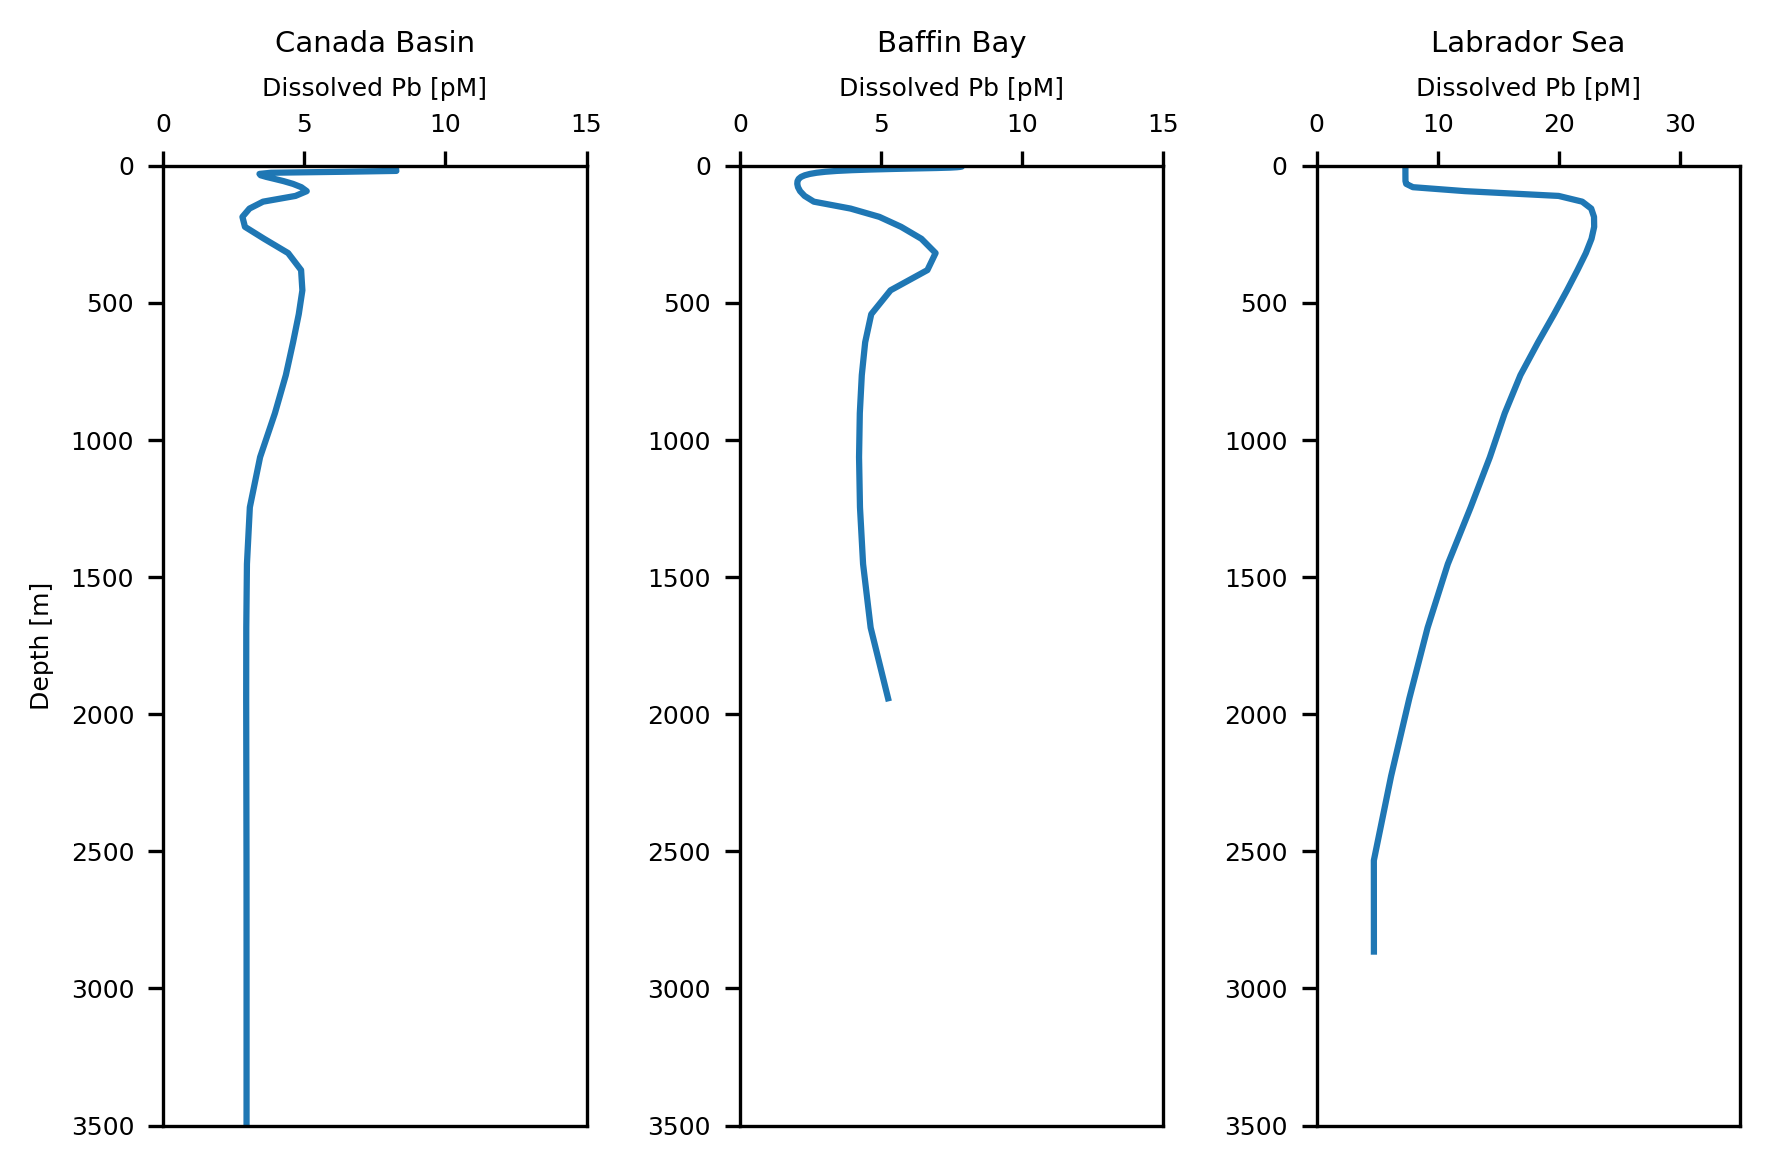

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(6,4), dpi=300)
for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)
    axis.invert_yaxis()
    axis.set_xlabel('Dissolved Pb [pM]', fontsize=6)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
    axis.set_xlim(0,15)
    axis.set_ylim(3500,0)
    
ax[2].set_xlim(0,35)

ax[0].set_ylabel('Depth [m]', fontsize=6)
ax[0].set_title('Canada Basin', fontsize=7)
ax[1].set_title('Baffin Bay', fontsize=7)
ax[2].set_title('Labrador Sea', fontsize=7)

ax[0].plot(dpb[:,900,450]*1e12, mesh_depth) # CB
ax[1].plot(dpb[:,280,420]*1e12, mesh_depth) # BB
ax[2].plot(dpb[:,50,400]*1e12, mesh_depth)  # LS

plt.tight_layout()